# Basic Notebook

This is a first basic notebook to make sure that things are generally running.

In [1]:
import os.path
import io
import itertools

import numpy as np
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib

from astropy.io import fits
from astropy.table import Table
import boto3

from decimal import Decimal
import math

directory = '/data/dwarf-galaxies-stamps2'
info_file = os.path.join(directory, 'stamps2.ecsv')

Using TensorFlow backend.


## User Methods

In [2]:
def display_image(position):
    image = train['features'][position].squeeze()
    minim, maxim = np.min(image), np.max(image)
    image = (image - minim) / (maxim - minim)
    plt.figure(1)
    plt.clf()
    plt.title('Example {}. Label: {}'.format(position, train['labels'][position]))
    plt.imshow(image[:,:,:3].astype(np.float64), cmap=plt.cm.gray_r)


def scale_column(column, value):
    vmin, vmax = column_scaling[column]['min'], column_scaling[column]['max']
    return (value - vmin) / (vmax - vmin)


def fexp(number):
    """
    Get the exponent
    """
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1


def roundup(number):
    """
    Round the number up to the nearest factor, but in a nice way
    """
    theexp = fexp(number)

    if theexp < 0:
        return math.ceil(number * 10**abs(theexp)) / (10**abs(theexp))
    else:
        return math.ceil(number * 10**abs(theexp-2)) / (10**abs(theexp-2))
    return
vroundup = np.vectorize(roundup)

def rounddown(number):
    """
    Round down to the nearest factor, but in a nice way
    """
    theexp = fexp(number)

    if theexp < 0:
        return math.floor(number / 10**abs(theexp)) * (10**abs(theexp))
    else:
        return math.floor(number * 10**abs(theexp-2)) / (10**abs(theexp-2))
    return
vrounddown = np.vectorize(rounddown)

def random_subsets(thelist, subsets):
    """
    Create random sugesets of data.

    I need to check to make sure the data exists and is non-zero as well
    """
    used = []

    for subset in subsets:
        all_used = list(itertools.chain(*used))

        possible = list(set(thelist) - set(all_used))

        thesublist = np.random.choice(possible, subset, replace=False)

        used.append(thesublist)

    return used


def load_data(dwarfs_table, indices):
    """
    Load the data and create the labels
    """

    N = len(indices)
    features = np.zeros((N, *crop, 5), dtype=np.float32)
    labels = np.zeros((N, 2))
    
    print('Loading data...')
    for ii, rowi in enumerate(indices):

        # Load the FITS data from S3
        filename = dwarfs_table[rowi]['filename']
        f = fits.open(os.path.join(directory, filename))

        # Re-jig it and add to the features and labels.
        data = f[0].data.astype(np.float16).transpose((1, 2, 0))[:256, :256] # move channels to last.

        features[ii] = data
        labels[ii] = np.array([scale_column(k, dwarfs_table[rowi][k]) for k in columns])
                
    print('Done Loading')
    return features, labels

## Load the Information File

In [4]:
crop = (256, 256)

dwarfs_table = Table.read(info_file, format='ascii.ecsv')
dwarfs_table

<Table length=12558>
                      filename                       logmass ... noise_z noise_y
                       str52                         float64 ... float64 float64
---------------------------------------------------- ------- ... ------- -------
stamps2/d14.79_m7.45_re0.35_feh-1.2_age10.0_HSC.fits  7.4485 ...  0.0349  0.0164
stamps2/d12.46_m6.72_re0.44_feh-1.5_age12.6_HSC.fits  6.7190 ...  0.0245  0.0281
 stamps2/d9.81_m8.47_re0.84_feh-1.0_age12.3_HSC.fits  8.4725 ...  0.0251  0.0167
 stamps2/d14.38_m5.08_re0.47_feh-2.0_age7.0_HSC.fits  5.0823 ...  0.0365  0.0319
stamps2/d11.95_m8.55_re1.34_feh-1.0_age13.7_HSC.fits  8.5475 ...  0.0372  0.0224
  stamps2/d9.74_m5.33_re0.46_feh-1.8_age7.7_HSC.fits  5.3289 ...  0.0179  0.0166
stamps2/d10.94_m5.00_re0.95_feh-1.5_age13.2_HSC.fits  5.0040 ...  0.0202  0.0344
stamps2/d12.95_m5.07_re0.21_feh-2.0_age11.4_HSC.fits  5.0731 ...  0.0233  0.0198
 stamps2/d7.03_m6.23_re0.47_feh-1.8_age11.3_HSC.fits  6.2316 ...  0.0374  0.0274
stamps2/d11.57_m5.17_re0.22_feh-2.0_age11.7_HSC.fits  5.1709 ...  0.0338  0.0230
                                                 ...     ... ...     ...     ...
 stamps2/d3.73_m7.66_re0.45_feh-1.2_age13.1_HSC.fits  7.6571 ...  0.0174  0.0350
 stamps2/d10.51_m5.05_re0.19_feh-2.0_age9.7_HSC.fits  5.0504 ...  0.0291  0.0190
stamps2/d10.23_m8.55_re0.72_feh-1.2_age10.8_HSC.fits  8.5462 ...  0.0320  0.0177
stamps2/d11.71_m6.42_re0.63_feh-1.5_age10.1_HSC.fits  6.4168 ...  0.0397  0.0283
 stamps2/d3.68_m5.31_re0.53_feh-2.0_age14.0_HSC.fits  5.3101 ...  0.0324  0.0192
stamps2/d14.93_m5.67_re0.21_feh-2.0_age12.0_HSC.fits  5.6689 ...  0.0299  0.0189
 stamps2/d11.84_m7.86_re0.43_feh-1.2_age8.2_HSC.fits  7.8559 ...  0.0179  0.0350
  stamps2/d4.90_m7.64_re0.43_feh-1.0_age8.7_HSC.fits  7.6398 ...  0.0163  0.0305
stamps2/d14.13_m5.68_re0.35_feh-1.8_age10.2_HSC.fits  5.6786 ...  0.0234  0.0307
stamps2/d11.39_m8.88_re1.23_feh-1.0_age12.0_HSC.fits  8.8764 ...  0.0161  0.0344

## Setup the Columns of Interest

In [5]:
# Calculate the scale factors for each attribute
#columns = ['distance', 'logmass', 'rekpc', 'FeH', 'age']
columns = ['distance', 'logmass']

column_scaling = {}
for column in columns:
  column_scaling[column] = {
      'min': np.min(vrounddown(dwarfs_table[column])), 
      'max': np.max(vroundup(dwarfs_table[column]))
  }

## Load the Data into Test and Train

Loading data...
Done Loading
Loading data...
Done Loading
# of training images: 8000
# of test images: 250


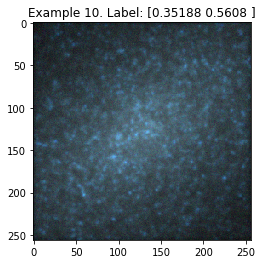

In [6]:
train = {}
test = {}

# All the indices
indices = range(len(dwarfs_table))

# training indices
training_test_indices = random_subsets(indices, [8000, 250])
training_indices, test_indices = training_test_indices[0], training_test_indices[1]

train['features'], train['labels'] = load_data(dwarfs_table, training_indices)
test['features'], test['labels'] = load_data(dwarfs_table, test_indices)

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

display_image(10)

## Split into Train and Validation

In [7]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 6400
# of validation images: 1600


## Compile the Neural Network

In [18]:
EPOCHS = 20
BATCH_SIZE = 100

model = keras.Sequential()

# 1st Convolutional Layer 
model.add(layers.Conv2D(filters=96, input_shape=(256,256,5), kernel_size=(11,11),\
strides=(4,4), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling 
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(layers.BatchNormalization())

# 2nd Convolutional Layer
model.add(layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 3rd Convolutional Layer
model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 4th Convolutional Layer
model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 5th Convolutional Layer
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
# Pooling
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(layers.BatchNormalization())

# Passing it to a dense layer
model.add(layers.Flatten())
# 1st Dense Layer
model.add(layers.Dense(4096, input_shape=(224*224*3,)))
model.add(layers.Activation('relu'))
# Add Dropout to prevent overfitting
model.add(layers.Dropout(0.4))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 2nd Dense Layer
model.add(layers.Dense(4096))
model.add(layers.Activation('relu'))
# Add Dropout
model.add(layers.Dropout(0.4))
# Batch Normalisation
model.add(layers.BatchNormalization())

# 3rd Dense Layer
model.add(layers.Dense(1000))
model.add(layers.Activation('relu'))
# Add Dropout
model.add(layers.Dropout(0.4))
# Batch Normalisation
model.add(layers.BatchNormalization())

# Output Layer
model.add(layers.Dense(2))

model.summary()

from keras.optimizers import SGD
model.compile(loss='mse', optimizer=SGD(lr=0.0001, momentum=0.9))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 96)        58176     
_________________________________________________________________
activation_9 (Activation)    (None, 62, 62, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 31, 31, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 21, 21, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 256)       0         
__________

## Train the Neural Network

In [30]:
EPOCHS=4

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = validation['features'], validation['labels']

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

import tensorflow as tf
import keras.backend as K
from keras.callbacks import Callback, LambdaCallback
def cb(x, y_true):
    def _(batch, logs):
        s,e=batch*batch_size,(batch+1)*batch_size
        y_pred = model.predict(
            x[s:e],
            batch_size=batch_size
        )
        print('pred {}'.format(y_pred))
        print('true {}'.format(y_true))
#         plt.clf()
#         plt.plot(y_true[s:e], label='true')
#         plt.plot(y_pred, label='pred')
#         plt.axis([0, batch_size, -1, 1])
#         plt.legend()
#         plt.draw()
#         plt.pause(0.0001)
    return _
cb_plot=keras.callbacks.LambdaCallback(on_batch_end=cb(X_train, y_train))


#train_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True).flow(X_train, y_train, batch_size=BATCH_SIZE)
train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

cbk = CollectOutputAndTarget()
fetches = [tf.assign(cbk.var_y_true, model.targets[0], validate_shape=False),
           tf.assign(cbk.var_y_pred, model.outputs[0], validate_shape=False)]
model._function_kwargs = {'fetches': fetches}  # use `model._function_kwargs` if using `Model` instead of `Sequential`

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[cb_plot])


# of training images: 6400
# of validation images: 1600
Epoch 1/4


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (6400, 256, 256, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1600, 256, 256, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


 1/64 [..............................] - ETA: 1:15 - loss: 0.0342

NameError: name 'batch_size' is not defined

## Show Training Output

250/250 [==============================] - 1s 4ms/step
Test loss: 0.09719133639335632
Test accuracy: 0.09719133639335632


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


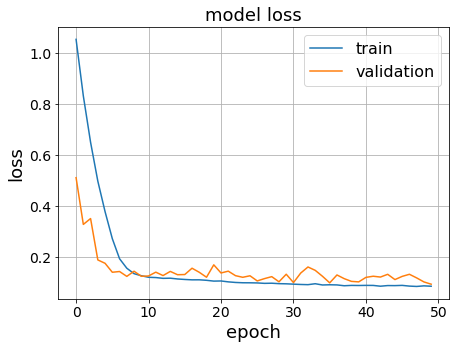

In [10]:
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)                                                                                                                                                                                               
score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(2, figsize=[7, 5])
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validation'], fontsize=16)
plt.grid('on')
plt.show()


## Show Results Compared to Truth

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


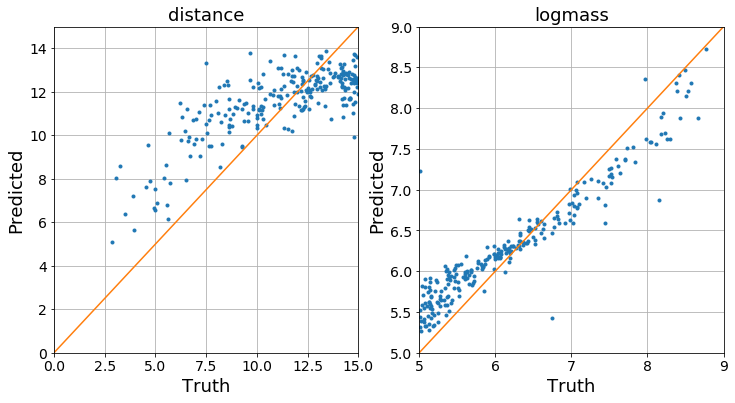

In [17]:
calculated = np.zeros((len(test_indices), len(columns)))
truth = np.zeros((len(test_indices), len(columns)))

for ii, test_indice in enumerate(test_indices):
    row = dwarfs_table[test_indice]
    f = fits.open(os.path.join(directory, row['filename']))

    data = f[0].data.astype(np.float16).transpose((1, 2, 0))[:256, :256] # move channels to last.

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[12, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 0.98, 'Training Data [Subset]')

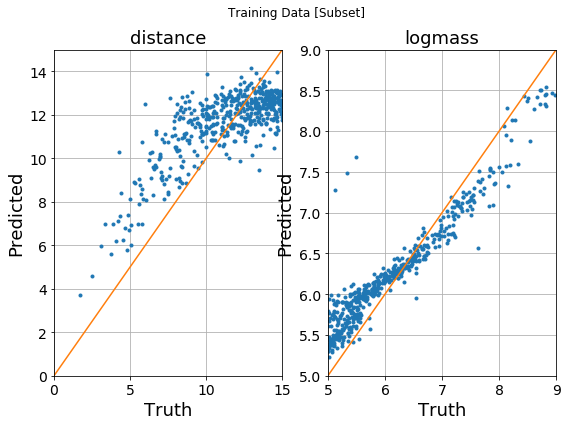

In [15]:
Ncompare = 500

calculated = np.zeros((Ncompare, len(columns)))
truth = np.zeros((Ncompare, len(columns)))

for ii, test_indice in enumerate(training_indices[:Ncompare]):
    row = dwarfs_table[test_indice]
    f = fits.open(os.path.join(directory, row['filename']))

    data = f[0].data.astype(np.float16).transpose((1, 2, 0))[:256, :256] # move channels to last.

    values = model.predict(data[None,:])[0]

    for jj, c in enumerate(columns):
        cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
        values[jj] = values[jj] * (cmax - cmin) + cmin

    calculated[ii] = values
    truth[ii] = [row[c] for c in columns]


plt.figure(3, figsize=[9, 6])
plt.clf()

cs = int(np.ceil(np.sqrt(len(columns))))
rs = int(len(columns) // cs)

for ci, c in enumerate(columns):
    plt.subplot(rs, cs, ci+1)
    plt.plot(truth[:, ci], calculated[:, ci], '.')
    plt.title(c, fontsize=18)
    cmin, cmax = column_scaling[c]['min'], column_scaling[c]['max']
    plt.xlim((cmin, cmax))
    plt.ylim((cmin, cmax))
    plt.grid('on')
    plt.xlabel('Truth', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.plot([cmin, cmax], [cmin, cmax])
plt.suptitle('Training Data [Subset]')


In [ ]:
train